# 5. Case study - case-study

In [1]:
options(stringsAsFactors = F)
library(reshape2)
library(ggplot2)
library(plyr)
library(stringr)
library(MASS)

#if (!file.exists("deaths.rds")) {
#  src <- "https://github.com/hadley/mexico-mortality/raw/master/deaths/deaths08.csv.bz2"
#  file.download(src, "deaths.csv.bz2", quiet = TRUE)
#  
#  deaths <- read.csv("deaths08.csv.bz2")
#  unlink("deaths08.csv.bz2")
#  deaths$hod[deaths$hod == 99] <- NA
#  deaths$hod[deaths$hod == 24] <- 0
#  deaths$hod[deaths$hod == 0] <- NA
#  deaths$hod <- as.integer(deaths$hod)  
#  deaths <- arrange(deaths, yod, mod, dod, hod, cod)
#  deaths <- deaths[c("yod", "mod", "dod", "hod", "cod")]
#  
#  saveRDS(deaths, "deaths.rds")
#}

deaths <- readRDS("../../case-study/deaths.rds")


Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


In [2]:
dim(deaths)
head(deaths)

[1] 539530      5

yod,mod,dod,hod,cod
0,0,0,NA,E14
0,0,0,NA,E46
0,0,0,NA,I21
0,0,0,NA,K70
0,0,0,NA,P21
0,0,0,NA,Q89


In [3]:
ok <- subset(deaths, yod == 2008 & mod != 0 & dod != 0)


In [4]:
dim(ok)
ok[c(1, 1:14 * 2000), c("yod", "mod", "dod", "hod", "cod")]

[1] 527429      5

,yod,mod,dod,hod,cod
11938,2008,1,1,1,B20
13937,2008,1,2,4,I67
15937,2008,1,3,8,I50
17937,2008,1,4,12,I50
19937,2008,1,5,16,K70
21937,2008,1,6,18,I21
23937,2008,1,7,20,I21
25937,2008,1,8,NA,K74
27937,2008,1,10,5,K74
29937,2008,1,11,9,I21


In [5]:
codes <- read.csv("../../case-study/icd-main.csv")
codes$disease <- sapply(codes$disease, function(x)
  str_c(strwrap(x, width = 30), collapse = "\n"))
names(codes)[1] <- "cod"
codes <- codes[!duplicated(codes$cod), ]


In [6]:
dim(codes)
head(codes)

[1] 1851    2

cod,disease
A00,Cholera
A01,Typhoid and paratyphoid fevers
A02,Other salmonella infections
A03,Shigellosis
A04,Other bacterial intestinal infections
A05,"Other bacterial foodborne intoxications, not elsewhere classified"


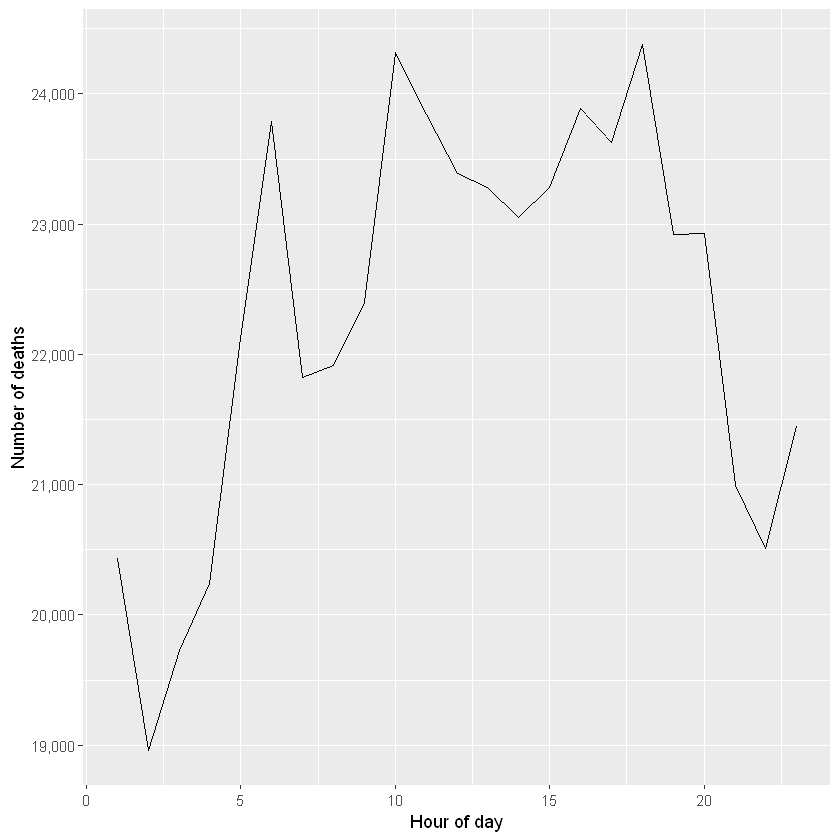

In [7]:
# Display overall hourly deaths
hod_all <- subset(count(deaths, "hod"), !is.na(hod))
qplot(hod, freq, data = hod_all, geom = "line") + 
  scale_y_continuous("Number of deaths", labels = function(x) format(x, big.mark = ",")) + 
  xlab("Hour of day")
#ggsave("overall.pdf", width = 10, height = 6)


In [8]:
# Count deaths per hour, per disease
hod2 <- count(deaths, c("cod", "hod"))
hod2 <- subset(hod2, !is.na(hod))
hod2 <- join(hod2, codes)
hod2 <- ddply(hod2, "cod", transform, prop = freq / sum(freq))


Joining by: cod


In [9]:
dim(hod2)
head(hod2)

[1] 15554     5

cod,hod,freq,disease,prop
A01,1,3,Typhoid and paratyphoid fevers,0.05769231
A01,2,1,Typhoid and paratyphoid fevers,0.01923077
A01,3,4,Typhoid and paratyphoid fevers,0.07692308
A01,5,5,Typhoid and paratyphoid fevers,0.09615385
A01,6,1,Typhoid and paratyphoid fevers,0.01923077
A01,8,1,Typhoid and paratyphoid fevers,0.01923077


In [10]:
# Compare to overall abundance
overall <- ddply(hod2, "hod", summarise, freq_all = sum(freq))
overall <- mutate(overall, prop_all = freq_all / sum(freq_all))

hod2 <- join(overall, hod2, by = "hod")

In [11]:
dim(hod2)
head(hod2)

[1] 15554     7

hod,freq_all,prop_all,cod,freq,disease,prop
1,20430,0.03980338,A01,3,Typhoid and paratyphoid fevers,0.05769231
1,20430,0.03980338,A02,3,Other salmonella infections,0.04838710
1,20430,0.03980338,A04,7,Other bacterial intestinal infections,0.05035971
1,20430,0.03980338,A05,1,"Other bacterial foodborne intoxications, not elsewhere classified",0.04761905
1,20430,0.03980338,A06,2,Amebiasis,0.02380952
1,20430,0.03980338,A09,112,Diarrhea and gastroenteritis of infectious origin,0.03664921


In [12]:
# Pick better subset of rows to show
cods <- join(arrange(count(deaths, "cod"), desc(freq)), codes)
#mutate(tail(subset(cods, freq > 100), 30), disease = str_sub(disease, 1, 30))

hod3 <- subset(hod2, cod %in% c("I21", "N18", "E84", "B16") & hod >= 8 & hod <= 12)[1:15, c("hod", "cod", "disease", "freq", "prop", "freq_all", "prop_all")]

devi <- ddply(hod2, "cod", summarise, n = sum(freq), dist = mean((prop - prop_all)^2))
devi <- subset(devi, n > 50)


Joining by: cod


In [13]:
dim(hod3)
head(hod3)
dim(devi)
head(devi)

[1] 15  7

,hod,cod,disease,freq,prop,freq_all,prop_all
4638,8,B16,Acute hepatitis B,4,0.038095238,21915,0.04269658
4787,8,E84,Cystic fibrosis,3,0.029411765,21915,0.04269658
4852,8,I21,Acute myocardial infarction,2205,0.047121426,21915,0.04269658
5028,8,N18,Chronic renal failure,315,0.041241163,21915,0.04269658
5305,9,B16,Acute hepatitis B,7,0.066666667,22401,0.04364344
5473,9,E84,Cystic fibrosis,1,0.009803922,22401,0.04364344


[1] 447   3

,cod,n,dist
1,A01,52,8.919359e-04
2,A02,62,7.380250e-04
4,A04,139,1.982786e-04
6,A06,84,4.395620e-04
9,A09,3056,2.838672e-05
10,A15,203,2.193798e-04


In [14]:
# Find outliers
xlog10 <- scale_x_log10(
  breaks = c(100, 1000, 10000), 
  labels = c(100, 1000, 10000), 
  minor_breaks = log10(outer(1:9, 10^(1:5), "*")))
ylog10 <- scale_y_log10(
  breaks = 10 ^ -c(3, 4, 5), 
  labels = c("0.001", "0.0001", "0.00001"),
  minor_breaks = log10(outer(1:9, 10^-(3:6), "*")))


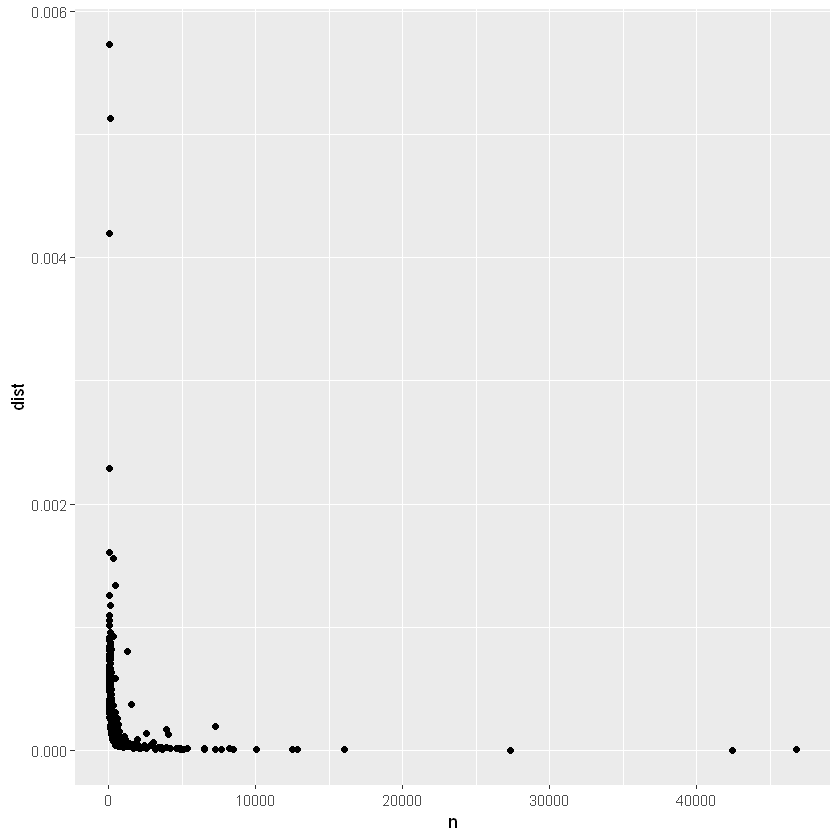

In [15]:
qplot(n, dist, data = devi)
#ggsave("n-dist-raw.pdf", width = 6, height = 6)


Warning message in self$trans$transform(self$minor_breaks):
"NaNs produced"

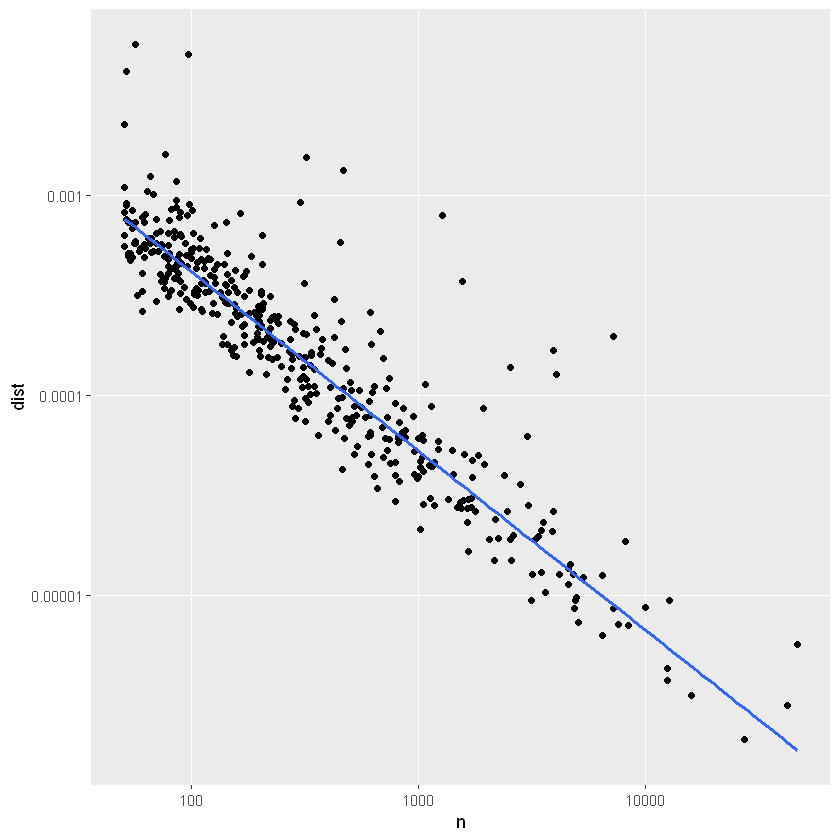

In [16]:
qplot(n, dist, data = devi) + 
  geom_smooth(method = "rlm", se = F) + 
  xlog10 + 
  ylog10
#ggsave("n-dist-log.pdf", width = 6, height = 6)


(Intercept)      log(n) 
 -3.6471353  -0.8970054

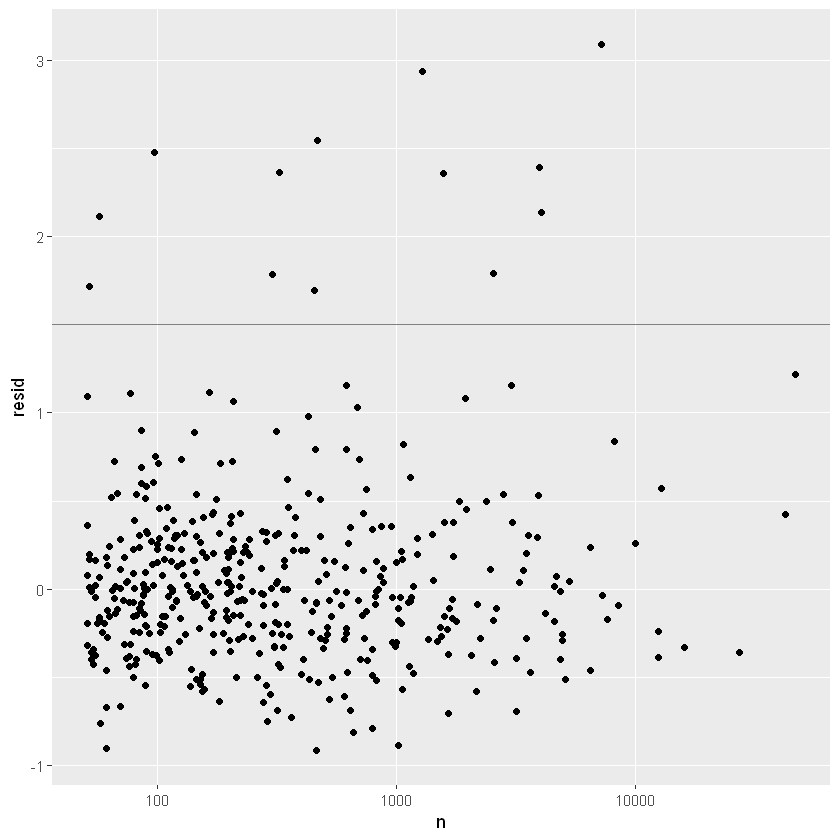

In [17]:
devi$resid <- resid(rlm(log(dist) ~ log(n), data = devi))
coef(rlm(log(dist) ~ log(n), data = devi))
ggplot(devi, aes(n, resid)) + 
  geom_hline(yintercept = 1.5, colour = "grey50") +
  geom_point() + 
  xlog10
#ggsave("n-dist-resid.pdf", width = 6, height = 6)


In [18]:
unusual <- subset(devi, resid > 1.5)
hod_unusual_big <- match_df(hod2, subset(unusual, n > 350))
hod_unusual_sml <- match_df(hod2, subset(unusual, n <= 350))


Matching on: cod
Matching on: cod


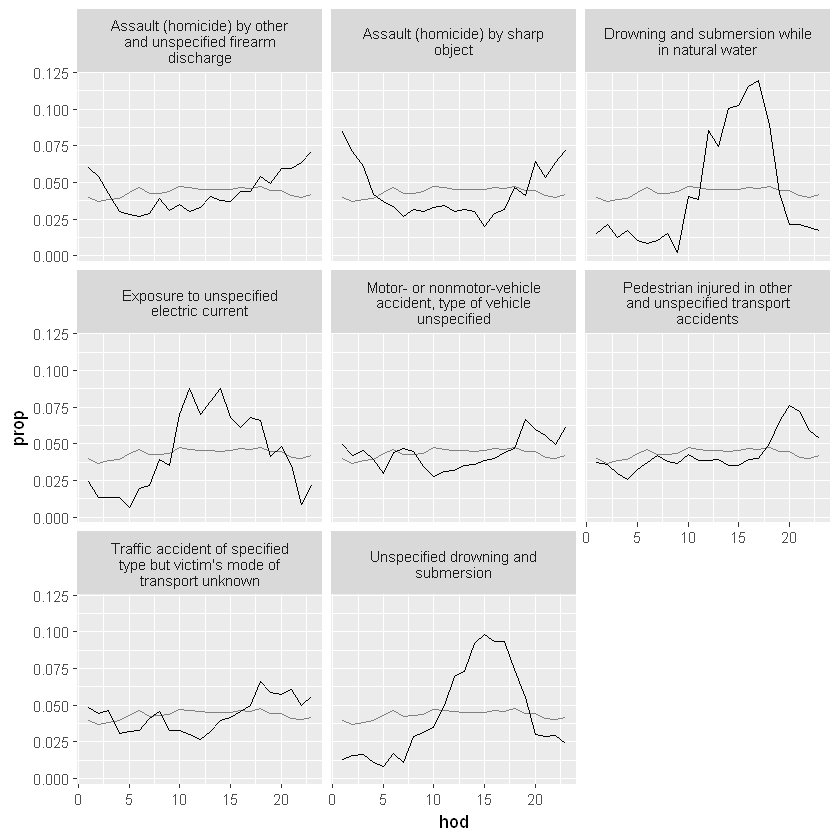

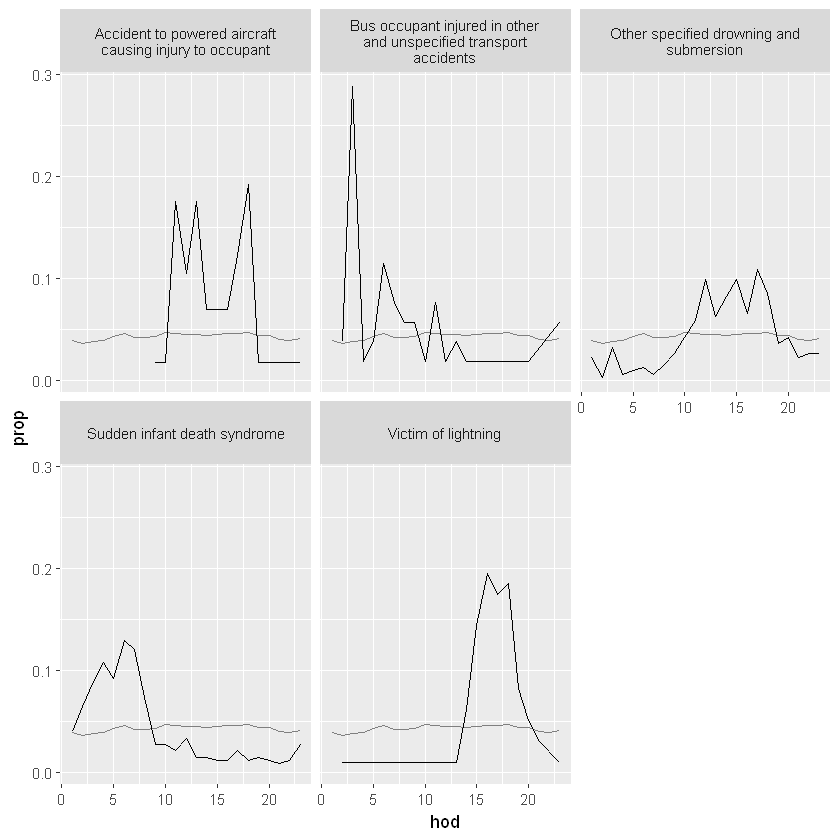

In [19]:
# Visualise unusual causes of death
ggplot(hod_unusual_big, aes(hod, prop)) + 
  geom_line(aes(y = prop_all), data = overall, colour = "grey50") +
  geom_line() + 
  facet_wrap(~ disease, ncol = 3)
#ggsave("unusual-big.pdf", width = 8, height = 6)
last_plot() %+% hod_unusual_sml
#ggsave("unusual-sml.pdf", width = 8, height = 4)
